<a href="https://colab.research.google.com/github/aishahismail3/Bank-Telemarketing-predicting-customer-subscription-/blob/main/Predicting_customer_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Statement: 
A bank performed a marketing campaign to track and predict the user behaviour. 
The marketing campaign was based on phone calls in order to assess if the product (bank term deposit) would be subscribed ('yes') or not subscribed ('no').


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#1. Libraries & read data

In [2]:
import pandas as pd
import numpy as np

#Plotting
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import init_notebook_mode,plot,iplot
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import warnings
warnings.filterwarnings("ignore")

# ML
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC 
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile 
from sklearn.feature_selection import RFE, chi2, mutual_info_classif,mutual_info_regression
from sklearn.feature_selection import f_regression,f_classif, f_oneway

from sklearn.model_selection import train_test_split, cross_val_score  # sklearn.cross_validation change to model_selection
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score
SEED = 42

#DL
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers


In [3]:
df_train = pd.read_excel('/content/drive/MyDrive/Daiichi/train_file.xlsx')
print('Train', df_train.shape)

Train (32910, 15)


#2. EDA

In [4]:
df_train.head(5)

age           job   marital  ... previous     poutcome    y
0   49   blue-collar   married  ...        0  nonexistent   no
1   37  entrepreneur   married  ...        1      failure   no
2   78       retired   married  ...        0  nonexistent  yes
3   36        admin.   married  ...        0  nonexistent   no
4   59       retired  divorced  ...        0  nonexistent   no

[5 rows x 15 columns]

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32910 non-null  int64 
 1   job          32910 non-null  object
 2   marital      32910 non-null  object
 3   education    32910 non-null  object
 4   default      32910 non-null  object
 5   housing      32910 non-null  object
 6   loan         32910 non-null  object
 7   contact      32910 non-null  object
 8   month        32910 non-null  object
 9   day_of_week  32910 non-null  object
 10  duration     32910 non-null  int64 
 11  campaign     32910 non-null  int64 
 12  previous     32910 non-null  int64 
 13  poutcome     32910 non-null  object
 14  y            32910 non-null  object
dtypes: int64(4), object(11)
memory usage: 3.8+ MB


#Data description
1.   age (numeric)
2.   job : type of job (categorical)
3.   marital : marital status (categorical)
4. education (categorical)
5. default : has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', …,'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue'..,'fri')
11. duration: duration of contact, in seconds (numeric)
12. campaign: number of contacts/ calls performed during this campaign 
13. previous: number of contacts performed before the campaign, for that client
14. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
15. Target : ' y' : indicating whether a client applied for term deposit or not. (binary: 'yes','no')


In [6]:
df_train.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
previous       0
poutcome       0
y              0
dtype: int64

2b. Rename column y to outcome for better understanding/ intrepretation

In [7]:
# rename column y to outcome
df_train.rename(columns = {'y':'outcome'}, inplace = True)

2c. create a duration in minutes column 

In [8]:
df_train['duration_min'] = round(df_train['duration']/60)

In [9]:
df_train.head(5)

age           job   marital  ...     poutcome outcome duration_min
0   49   blue-collar   married  ...  nonexistent      no          4.0
1   37  entrepreneur   married  ...      failure      no          3.0
2   78       retired   married  ...  nonexistent     yes         19.0
3   36        admin.   married  ...  nonexistent      no          2.0
4   59       retired  divorced  ...  nonexistent      no          6.0

[5 rows x 16 columns]

In [10]:
df_train.describe()

age      duration      campaign      previous  duration_min
count  32910.000000  32910.000000  32910.000000  32910.000000  32910.000000
mean      40.014099    258.164327      2.560620      0.174810      4.296901
std       10.402948    259.070260      2.753336      0.499211      4.332836
min       17.000000      0.000000      1.000000      0.000000      0.000000
25%       32.000000    103.000000      1.000000      0.000000      2.000000
50%       38.000000    180.000000      2.000000      0.000000      3.000000
75%       47.000000    319.000000      3.000000      0.000000      5.000000
max       98.000000   4918.000000     56.000000      7.000000     82.000000

In [11]:
df_train.nunique()

age               75
job               12
marital            4
education          8
default            3
housing            3
loan               3
contact            2
month             10
day_of_week        5
duration        1467
campaign          40
previous           8
poutcome           3
outcome            2
duration_min      59
dtype: int64

2d. Previous can be categorized

In [12]:
df_train.previous.value_counts()

0    28380
1     3669
2      606
3      175
4       60
5       14
6        5
7        1
Name: previous, dtype: int64

In [13]:
# previous: number of contacts performed before this campaign and for this client- change to cat

df_train['previous'] = df_train['previous'].astype('object')
df_train.dtypes

age               int64
job              object
marital          object
education        object
default          object
housing          object
loan             object
contact          object
month            object
day_of_week      object
duration          int64
campaign          int64
previous         object
poutcome         object
outcome          object
duration_min    float64
dtype: object

In [14]:
df_train.outcome.value_counts()

no     29203
yes     3707
Name: outcome, dtype: int64

#2e. Distribution analysis

In [15]:
fig = px.histogram(df_train, x="outcome", text_auto=True)
iplot(fig)

fig1 = px.histogram(df_train, x='job', color='outcome' , barmode='group', text_auto=True)
iplot(fig1)

fig2 = px.histogram(df_train, x='marital', color='outcome', barmode='group', text_auto=True)
iplot(fig2)

fig3 = px.histogram(df_train, x='education', color='outcome', barmode='group', text_auto=True)
iplot(fig3)

fig4 = px.histogram(df_train, x='default', color='outcome',  barmode='group', text_auto=True)
iplot(fig4)

fig5 = px.histogram(df_train, x='housing', color='outcome',  barmode='group', text_auto=True)
iplot(fig5)

fig6 = px.histogram(df_train, x='loan', color='outcome',  barmode='group', text_auto=True)
iplot(fig6)

fig7 = px.histogram(df_train, x='contact', color='outcome', barmode='group', text_auto=True)
iplot(fig7)

fig8 = px.histogram(df_train, x='month', color='outcome',  barmode='group', text_auto=True)
iplot(fig8)

fig9 = px.histogram(df_train, x='day_of_week', color='outcome',  barmode='group', text_auto=True)
iplot(fig9)

fig10 = px.histogram(df_train, x='previous', color='outcome',  barmode='group', text_auto=True)
iplot(fig10)

fig11 = px.histogram(df_train, x='poutcome', color='outcome', barmode='group', text_auto=True)
iplot(fig11)

2e. Univariate & outliers analysis

Preprosessing: binning for age and campaign

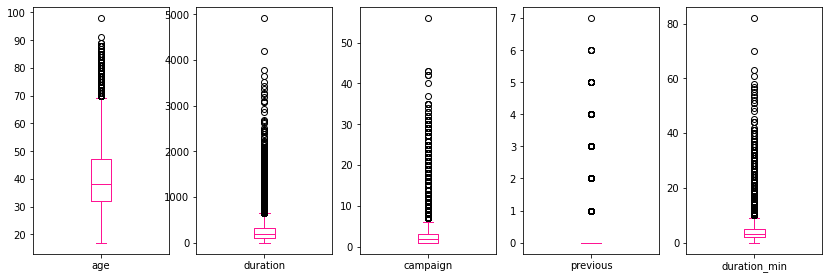

In [16]:
df_train.plot(kind='box', subplots=True, layout=(2,7),
        sharex=False,sharey=False, figsize=(20, 10), color='deeppink');

In [17]:
#  visualize distribution for age

fig24 = px.histogram(df_train, x='age', color='outcome', text_auto=True)
iplot(fig24)

In [18]:
# # visualize outliers = above 70 consider outliers

fig25 = px.box(df_train, y='age', color='outcome')
iplot(fig25)

In [19]:
# # make bin
# df_train['age_group'] = pd.cut(df_train['age'], [0, 25, 30, 40, 50, 60, 70, 100])

# df_train['age_group'] = df_train['age_group'].astype('str') # change to str bcoz binning is json

# fig26 = px.histogram(df_train, x='age_group', color='outcome', text_auto=True)

# iplot(fig26)

In [20]:
fig26 = px.histogram(df_train, x='campaign', color='outcome', text_auto=True)
iplot(fig26)

In [21]:
# visualize outliers = above 7 consider outliers

fig27 = px.box(df_train, y='campaign', color='outcome')
iplot(fig27)

In [22]:
# # make bin
# df_train['campaign_group'] = pd.cut(df_train['campaign'], [0, 7,10, 60, 70])

# df_train['campaign_group'] = df_train['campaign_group'].astype('str') # change to str bcoz binning is json

# fig28 = px.box(df_train, y='campaign', color='outcome')
# iplot(fig28)

In [23]:
# fig29 = px.histogram(df_train, x='campaign_group', color='outcome', text_auto=True)
# iplot(fig29)

In [24]:
fig30 = px.histogram(df_train, x='duration')
iplot(fig30)

In [25]:
fig30 = px.histogram(df_train, x='duration_min')
iplot(fig30)

In [26]:
fig31 = px.box(df_train, y='duration', color='outcome')
iplot(fig31)

In [27]:
fig = px.scatter(df_train,x='duration', y='campaign', color="outcome")
fig.show()

We can see that there are seperate clusters between 'yes' & 'no'. 

1.   YES were contacted fewer times but have longer duration call
2.   NO were contacted many time but at shorter duration
3. after like '7' campaign calls, clients are likely to reject
4. most of "YES" were called less than 7 times but at longer duration

maybe bank should have less calls, which can be disturbing and increase dissatisfaction.

#2f. Corelation Between Qualitative Variables

In [28]:
df_train['outcome'] = df_train.outcome.replace({"no": 0, "yes": 1})

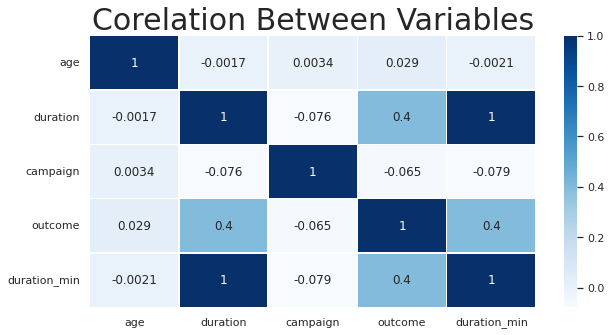

In [29]:
sns.set(style="white") 
plt.rcParams['figure.figsize'] = (10, 5) 
sns.heatmap(df_train.corr(), annot = True, linewidths=.5, cmap="Blues")
plt.title('Corelation Between Variables', fontsize = 30)
plt.show()

correlation with all qualitative variables. Clearly, 

1.   campaign has a strong correlation with outcome
2.   previous has a moderate correlation with outcome
3.   age has a low correlation with outcome

will investigate further using feature importance.

2g.Check for duplicates

In [30]:
duplicated = df_train.duplicated().sum()
if duplicated:
    print('Duplicates Rows in Dataset are : {}'.format(duplicated))
else:
    print('Dataset contains no Duplicate Values')


df_train[df_train.duplicated(keep='first')]   # list out

Duplicates Rows in Dataset are : 8


age          job   marital  ...     poutcome outcome duration_min
1923    39       admin.   married  ...  nonexistent       0          2.0
12252   36      retired   married  ...  nonexistent       0          1.0
20067   35       admin.   married  ...  nonexistent       0          6.0
24831   41   technician   married  ...  nonexistent       0          2.0
28456   55     services   married  ...  nonexistent       0          1.0
29543   47   technician  divorced  ...  nonexistent       0          1.0
30807   71      retired    single  ...  nonexistent       0          2.0
32607   39  blue-collar   married  ...  nonexistent       0          2.0

[8 rows x 16 columns]

In [31]:
# drop the duplicates
df_train.drop_duplicates(keep='first',inplace=True)
df_train.shape

(32902, 16)

In [32]:
df_train.dtypes

age               int64
job              object
marital          object
education        object
default          object
housing          object
loan             object
contact          object
month            object
day_of_week      object
duration          int64
campaign          int64
previous         object
poutcome         object
outcome           int64
duration_min    float64
dtype: object

In [33]:
df_train.head(2)

age           job  marital  ...     poutcome outcome duration_min
0   49   blue-collar  married  ...  nonexistent       0          4.0
1   37  entrepreneur  married  ...      failure       0          3.0

[2 rows x 16 columns]

#3. Data prep

In [34]:
#Feature encoding for categorical variables
le = LabelEncoder()

df_train['job'] = le.fit_transform(df_train['job'])
df_train['marital'] = le.fit_transform(df_train['marital'])
df_train['education'] = le.fit_transform(df_train['education'])
df_train['default'] = le.fit_transform(df_train['default'])
df_train['housing'] = le.fit_transform(df_train['housing'])
df_train['loan'] = le.fit_transform(df_train['loan'])
df_train['contact'] = le.fit_transform(df_train['contact'])
df_train['month'] = le.fit_transform(df_train['month'])
df_train['day_of_week'] = le.fit_transform(df_train['day_of_week'])
df_train['previous'] = le.fit_transform(df_train['previous'])
df_train['poutcome'] = le.fit_transform(df_train['poutcome'])
# df_train['age_group'] = le.fit_transform(df_train['age_group'])
# df_train['campaign_group'] = le.fit_transform(df_train['campaign_group'])


# ########### Target variable encode specific
# df_train['outcome'] = df_train.outcome.replace({"no": 0, "yes": 1})
df_train.head(2)

age  job  marital  education  ...  previous  poutcome  outcome  duration_min
0   49    1        1          2  ...         0         1        0           4.0
1   37    2        1          6  ...         1         0        0           3.0

[2 rows x 16 columns]

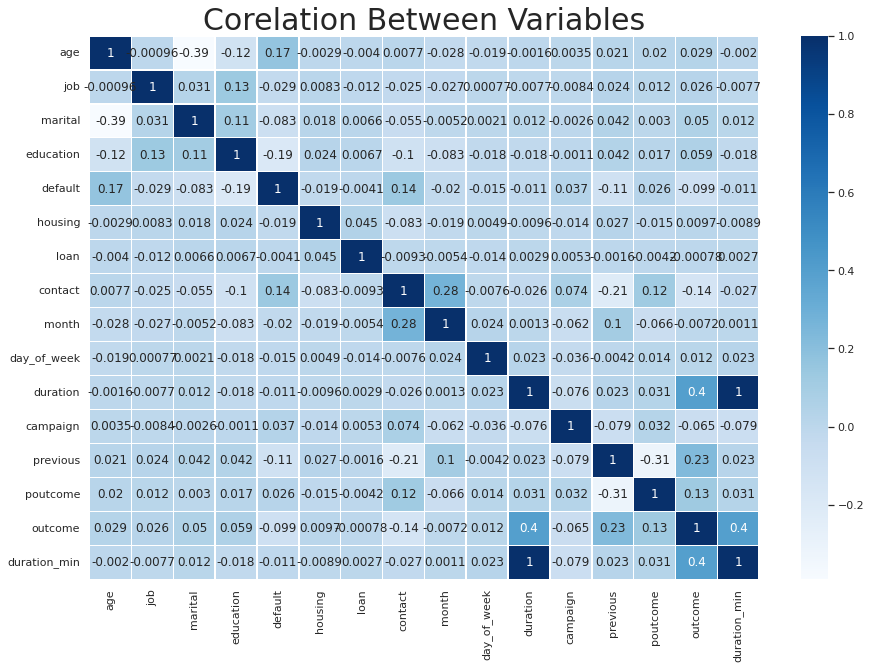

In [35]:
sns.set(style="white") 
plt.rcParams['figure.figsize'] = (15, 10) 
sns.heatmap(df_train.corr(), annot = True, linewidths=.5, cmap="Blues")
plt.title('Corelation Between Variables', fontsize = 30)
plt.show()

In [36]:
df_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
       'poutcome', 'outcome', 'duration_min'],
      dtype='object')

In [37]:
features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
       'poutcome'
      #  , 'age_group', 'campaign_group'
       ]
X = df_train[features]
y = df_train["outcome"]
print(X.shape)
print(y.shape)

# min_max_scaler = MinMaxScaler()
sc = StandardScaler()
X_scale = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=.2, stratify=y) #startify coz inbalance
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

(32902, 14)
(32902,)
X_train (26321, 14)
y_train (26321,)
X_test (6581, 14)
y_test (6581,)


#4 Feature Selection/Importance

Text(0.5, 1.0, 'Top Features derived by Random Forest')

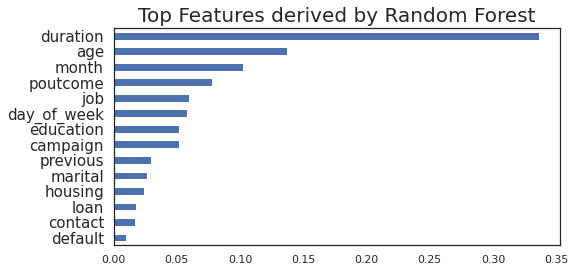

In [38]:
# feature importance using RF

rfc = RandomForestClassifier(random_state=SEED, n_estimators=100)

# Train model, note that NO scaling is required
rfc_model = rfc.fit(X, y)

# Plot the top features based on its importance
(pd.Series(rfc_model.feature_importances_, index=X.columns)
    .nlargest(16)   # can adjust based on how many top features you want
    .plot(kind='barh', figsize=[8,4])
    .invert_yaxis()) # most importance is on top, in descending order

plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=20)

Text(0.5, 1.0, 'Top Features derived by Extra Tree Classifier')

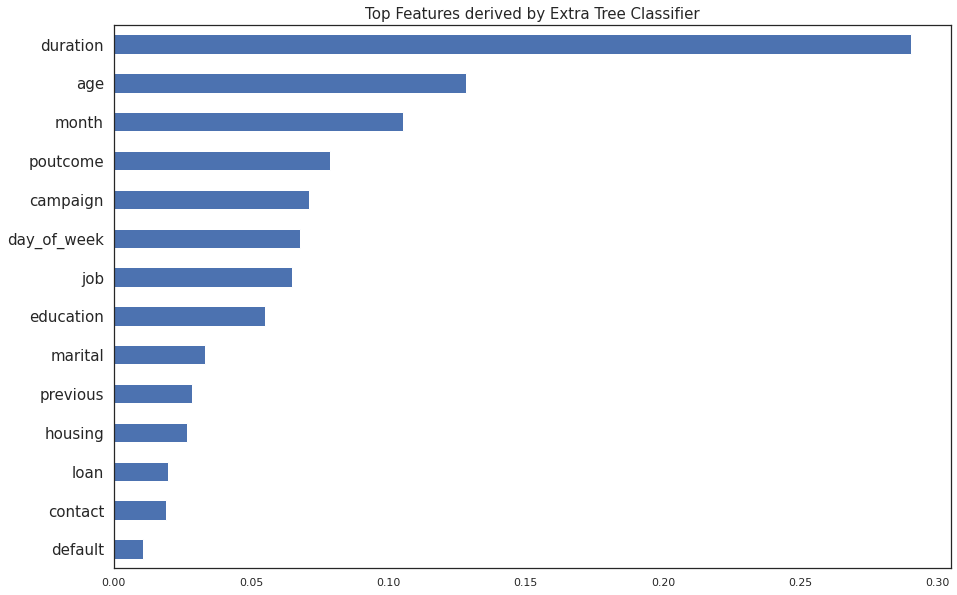

In [39]:
# feature importance using ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_scale,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

feat_importances = pd.Series(model.feature_importances_, index=X.columns) #plot graph
feat_importances.nlargest(14).plot(kind='barh').invert_yaxis()
plt.yticks(size=15)
plt.title('Top Features derived by Extra Tree Classifier', size=15)

In [40]:
# RFE

sel = RFE(GradientBoostingClassifier(n_estimators=100, random_state=0), n_features_to_select= 10)
sel.fit(X_train,y_train)
sel.get_support()
X.columns[sel.get_support()] # to get the name

Index(['age', 'job', 'education', 'default', 'contact', 'month', 'day_of_week',
       'duration', 'previous', 'poutcome'],
      dtype='object')

Feature importance:

1. **Duration** - distribution shows <1000 secs (16 min), shorter duration calls 

2. **age**- potential client btwn 30-50 (working adult perhaps). Higher % is btwn 30-50, marketing should target more in this age range.

3. **month** - bank contacted most clients between May and August. The highest contact rate is around May, while low contact rate in March, September, October, and December. Maybe due to sesonality

4. **Poutcome**- outcome of the previous marketing campaign (failure,nonexistent,success)

5. **Campaign** - distribution shows 0-3, >7 is outliers, the more calls made, higher chance of client to reject. 

6.  **Job** - potential client admin, blue-colar, technician, services, management tend to subscribe


#5a. Base Model with all features

In [41]:
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
logreg = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
svc = SVC()
linearsvc = LinearSVC()
svmsvc = svm.SVC(kernel='linear', gamma='auto', C=2)
svmsvcrbf = svm.SVC(kernel='rbf', gamma='auto', C=2)
svmsvcP = svm.SVC(kernel='poly', gamma='auto', C=2)

xgb = XGBClassifier(n_estimators=100)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='f1'))

# MAKE A TABLE OF RESULTS

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score]})   # timetaken: to be used for comparison later
    return df_model

In [42]:
# Concat all models as dataframe
df_models = pd.concat([baseline_report(gnb, X_train, X_test, y_train, y_test,'GaussianNB'),
                      #  baseline_report(bnb, X_train, X_test, y_train, y_test,'BernoulliNB'),
                      #  baseline_report(mnb, X_train, X_test, y_train, y_test,'MultinomialNB'),
                       baseline_report(logreg, X_train, X_test, y_train, y_test, 'LogisticRegression'),
                       baseline_report(knn, X_train, X_test, y_train, y_test, 'KNN'),
                       baseline_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree'),
                       baseline_report(rfc, X_train, X_test, y_train, y_test, 'RandomForest'),
                      #  baseline_report(svc, X_train, X_test, y_train, y_test, 'SVC'),
                      #  baseline_report(svmsvc, X_train, X_test, y_train, y_test, 'SVM_SVC'),
                      #  baseline_report(svmsvcrbf, X_train, X_test, y_train, y_test, 'SVM_SVC_RBF'),
                      #  baseline_report(svmsvcP, X_train, X_test, y_train, y_test, 'SVM_SVC_Poly'),
                       baseline_report(xgb, X_train, X_test, y_train, y_test, 'xgb'),
                       ], axis=0).reset_index()
df_models = df_models.drop('index', axis=1)
df_models

model  accuracy  precision    recall   f1score
0          GaussianNB  0.845561   0.365902  0.505407  0.424350
1  LogisticRegression  0.901637   0.640782  0.292304  0.400676
2                 KNN  0.896394   0.575172  0.307816  0.400729
3        DecisionTree  0.871623   0.427761  0.470333  0.443523
4        RandomForest  0.902359   0.608299  0.376610  0.464578
5                 xgb  0.906310   0.643834  0.378295  0.476213

Performance metrics to measure are F1 score, [recision and recall because dataset are highly imbalanced

#5b. Base model with selected feature

In [43]:
# feature = ['age', 'job', 'education', 'default', 'contact', 'month', 'duration','previous', 'poutcome']
# X2 = df_train[feature]
# y2 = df_train["outcome"]
# # print(X.shape)
# # print(y.shape)

# # min_max_scaler = MinMaxScaler()
# sc = StandardScaler()
# X_scale2 = sc.fit_transform(X2)

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scale2, y2, test_size=.2, stratify=y) #startify coz inbalance
# print('X_train2', X_train.shape)
# print('y_train2', y_train.shape)
# print('X_test2', X_test.shape)
# print('y_test2', y_test.shape)

In [44]:
# gnb = GaussianNB()
# bnb = BernoulliNB()
# mnb = MultinomialNB()
# logreg = LogisticRegression()
# knn = KNeighborsClassifier()
# decisiontree = DecisionTreeClassifier()
# randomforest = RandomForestClassifier()
# svc = SVC()
# linearsvc = LinearSVC()
# svmsvc = svm.SVC(kernel='linear', gamma='auto', C=2)
# svmsvcrbf = svm.SVC(kernel='rbf', gamma='auto', C=2)
# svmsvcP = svm.SVC(kernel='poly', gamma='auto', C=2)

# xgb = XGBClassifier(n_estimators=100)

# kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
# def baseline_report(model, X_train2, X_test2, y_train2, y_test2, name):
#     model.fit(X_train2, y_train2)
#     accuracy     = np.mean(cross_val_score(model, X_train2, y_train2, cv=kf, scoring='accuracy'))
#     precision    = np.mean(cross_val_score(model, X_train2, y_train2, cv=kf, scoring='precision'))
#     recall       = np.mean(cross_val_score(model, X_train2, y_train2, cv=kf, scoring='recall'))
#     f1score      = np.mean(cross_val_score(model, X_train2, y_train2, cv=kf, scoring='f1'))

# # MAKE A TABLE OF RESULTS

#     df_model = pd.DataFrame({'model'        : [name],
#                              'accuracy'     : [accuracy],
#                              'precision'    : [precision],
#                              'recall'       : [recall],
#                              'f1score'      : [f1score]})   # timetaken: to be used for comparison later
#     return df_model

In [45]:
# # Concat all models
# df_model2 = pd.concat([baseline_report(gnb, X_train2, X_test2, y_train2, y_test2,'GaussianNB'),
#                        baseline_report(logreg, X_train2, X_test2, y_train2, y_test2, 'LogisticRegression'),
#                        baseline_report(knn, X_train2, X_test2, y_train2, y_test2, 'KNN'),
#                        baseline_report(decisiontree, X_train2, X_test2, y_train2, y_test2, 'DecisionTree'),
#                        baseline_report(rfc, X_train2, X_test2, y_train2, y_test2, 'RandomForest'),
#                        baseline_report(svc, X_train2, X_test2, y_train2, y_test2, 'SVC'),
#                        baseline_report(xgb, X_train2, X_test2, y_train2, y_test2, 'xgb'),
#                        ], axis=0).reset_index()
# df_model2 = df_model2.drop('index', axis=1)
# df_model2

#achived same performance but with less features


# 5c. Hyperparameter tuning for top 3 model with best f1 score RF, XGB, log reg

In [46]:
#define metrics for tuning

def model_report(model, X_train, X_test, y_train, y_test, model_name):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            if th<0: 
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display f1score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    accuracy      = model.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
#     y_pred = [1 if x==True else 0 if x==False else x for x in y_pred]   # .predict->0/1; .predict_proba->False/True
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = model.predict_proba(X_test)[:,1]   # use this at optimal th, for AUC and logloss
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(rocauc))
    logloss      = log_loss(y_test, y_pred)   # same result using y_pred = model.predict_proba(X_test)
    print(model_name, 'Log-loss: {:.4f}'.format(logloss))

    df2_model = pd.DataFrame({'model'       : [model_name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [1000]})   # timetaken for comparison later
    return df2_model

In [47]:
print('\n"""""" LogisticRegression """"""')
time1 = time.time()
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(10) Cross Validation on train data')
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)
for c in c_list:
    logreg = LogisticRegression(C = c)
    cvs = (cross_val_score(logreg, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

logreg = LogisticRegression(C = optimal_c)
model1 = model_report(logreg, X_train, X_test, y_train, y_test, 'LogisticRegression')
model1.timetaken[0] = time.time() - time1


"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(10) Cross Validation on train data
0.2661, 0.2786, 0.2865, 0.2953, 0.3012, 0.3078, 0.3136, 0.3194, 0.3230, 0.3269, 0.3301, 0.3359, 0.3419, 0.3432, 0.3464, 0.3494, 0.3521, 0.3535, 0.3558, 0.3584, 0.3639, 0.3661, 0.3683, 0.3696, 0.3721, 0.3740, 0.3775, 0.3784, 0.3794, 0.3803, 0.3809, 0.3809, 0.3813, 0.3813, 0.3815, 0.3827, 0.3838, 0.3851, 0.3868, 0.3872, 0.3879, 0.3892, 0.3894, 0.3909, 0.3912, 0.3921, 0.3929, 0.3940, 0.3950, 0.3950, 0.3953, 0.3951, 0.3962, 0.3962, 0.3962, 0.3965, 0.3965, 0.3964, 0.3974, 0.3974, 0.3981, 0.3981, 0.3980, 0.3986, 0.3985, 0.3992, 0.3995, 0.3995, 0.3995, 0.3995, 0.3995, 0.3994, 0.3994, 0.3994, 0.3993, 0.3996, 0.3996, 0.3996, 0.3996, 0.3996, 0.3996, 0.3996, 0.3996, 0.3996, 0.3996, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4004, 0.4004, 0.4004, 0.4004, 0.4004, 0.4004, 0.4008, 0.4008, 0.4008, 0.4008, 0.4008, 0.4008, 0.4008,

In [48]:
print('\n"""""" RandomForestClassifier """""" (quite slow)')
time1 = time.time()
print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 400, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

randomforest = RandomForestClassifier(n_estimators=optimal_n)
model2 = model_report(randomforest, X_train, X_test, y_train, y_test, 'RandomForest')
model2.timetaken[0] = time.time() - time1
# Note: results keep changing in each run coz small dataset


"""""" RandomForestClassifier """""" (quite slow)

Search for optimal n_estimators in RandomForest, vary 100 to 400, using KFold(5) Cross Validation on train data
100->0.4694, 150->0.4677, 200->0.4718, 250->0.4751, 300->0.4679, 350->0.4754, 400->0.4755, optimal F1 score = 0.4755
optimal n_estimators = 400

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.2378,  0.100->0.5268,  0.200->0.6013,  0.300->0.6023,  0.400->0.5826,  0.500->0.5188,  0.600->0.3851,  0.700->0.2301,  0.800->0.0992,  0.900->0.0081,  1.000->0.0000,  
Looping decimal place 2
0.200->0.6013,  0.210->0.6060,  0.220->0.6065,  0.230->0.6069,  0.240->0.6118,  0.250->0.6130,  0.260->0.6113,  0.270->0.6044,  0.280->0.6069,  0.290->0.6007,  0.300->0.6023,  0.310->0.6018,  0.320->0.6038,  0.330->0.6030,  0.340->0.6025,  0.350->0.5982,  0.360->0.5934,  0.370->0.5912,  0.380->0.5896,  0.390->0.5874,  0.400->0.5826,  
Looping decimal place 3
0.240->0.6118, 

In [49]:
print('\n"""""" XGBClassifier """""" (quite slow)')
time1 = time.time()
print('\nSearch for optimal n_estimators in XGB, vary 100 to 400, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400]:
    xgb_tune = XGBClassifier(n_estimators=n)
    cvs = (cross_val_score(xgb_tune, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

xgb_tune = XGBClassifier(n_estimators=optimal_n)
model3 = model_report(xgb_tune, X_train, X_test, y_train, y_test, 'XGB')
model3.timetaken[0] = time.time() - time1
# Note: results keep changing in each run coz small dataset


"""""" XGBClassifier """""" (quite slow)

Search for optimal n_estimators in XGB, vary 100 to 400, using KFold(5) Cross Validation on train data
100->0.4823, 150->0.4978, 200->0.5045, 250->0.5101, 300->0.5119, 350->0.5120, 400->0.5158, optimal F1 score = 0.5158
optimal n_estimators = 400

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.2150,  0.100->0.5587,  0.200->0.6152,  0.300->0.6273,  0.400->0.5982,  0.500->0.5540,  0.600->0.4573,  0.700->0.3417,  0.800->0.2173,  0.900->0.0891,  1.000->0.0000,  
Looping decimal place 2
0.200->0.6152,  0.210->0.6181,  0.220->0.6206,  0.230->0.6237,  0.240->0.6223,  0.250->0.6206,  0.260->0.6218,  0.270->0.6258,  0.280->0.6256,  0.290->0.6261,  0.300->0.6273,  0.310->0.6249,  0.320->0.6204,  0.330->0.6202,  0.340->0.6192,  0.350->0.6146,  0.360->0.6113,  0.370->0.6104,  0.380->0.6019,  0.390->0.5974,  0.400->0.5982,  
Looping decimal place 3
0.290->0.6261,  0.291->0.6253,  0

In [50]:
# run tuned models as dataframe
df2_models_tuned = pd.concat([model1,model2,model3],
                            axis = 0).reset_index()
df2_models_tuned.drop('index', axis=1, inplace=True)
df2_models_tuned

model  accuracy  precision  ...    rocauc   logloss  timetaken
0  LogisticRegression  0.902598   0.526252  ...  0.885826  0.246905         92
1        RandomForest  0.910500   0.510259  ...  0.926529  0.204530        200
2                 XGB  0.914603   0.567067  ...  0.932913  0.195550         95

[3 rows x 8 columns]

#5d. Hyperparameter tune for XGB

In [51]:
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [52]:
# def objective(space):
#     clf=XGBClassifier(
#                     n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
#                     reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                     colsample_bytree=int(space['colsample_bytree']))
    
#     evaluation = [( X_train, y_train), ( X_test, y_test)]
    
#     clf.fit(X_train, y_train,
#             eval_set=evaluation, eval_metric="auc",
#             early_stopping_rounds=10,verbose=False)
    

#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }


# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'seed': 0  }

# trials = Trials()

In [53]:
# #Run tuning

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

In [54]:
# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)

#6 ML Model Selection (Random Forest with n=350): based on


1.   performance metrics
2.   model complexicity & stability
3.   computing resources



In [55]:
# #Define model
# rfc = RandomForestClassifier()
# rfc_tune = RandomForestClassifier(n_estimators=350)
# xgb = XGBClassifier()
# model_xgb = XGBClassifier(n_estimators=400,
#                           colsample_bytree=0.6969692678228745, 
#                           gamma= 2.654329110850134, 
#                           max_depth =13, 
#                           min_child_weight = 8, 
#                           reg_alpha = 83, 
#                           reg_lambda= 0.990156)

# #define metrics

# kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
# def baseline_report(model, X_train, X_test, y_train, y_test, name):
#     model.fit(X_train, y_train)
#     accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
#     precision    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='precision'))
#     recall       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='recall'))
#     f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='f1'))

# # MAKE A TABLE OF RESULTS

#     df_model3 = pd.DataFrame({'model'        : [name],
#                              'accuracy'     : [accuracy],
#                              'precision'    : [precision],
#                              'recall'       : [recall],
#                              'f1score'      : [f1score]})   # timetaken: to be used for comparison later
#     return df_model3

In [56]:
# #run model for comparison
# df_model3 = pd.concat([baseline_report(rfc, X_train, X_test, y_train, y_test, 'rfc'),
#                        baseline_report(rfc_tune, X_train, X_test, y_train, y_test, 'rfc_tune'),
#                        baseline_report(xgb, X_train, X_test, y_train, y_test, 'xgb'),
#                        baseline_report(model_xgb, X_train, X_test, y_train, y_test, 'xgb_tune'),
#                        ], axis=0).reset_index()
# df_model3 = df_model3.drop('index', axis=1)
# df_model3

Hyperparameter tuning did not improve f1 score as excpected. 

#7a. Deep Learning: •	Implement the task using deep learning and evaluate performance.

I will not use DL here. DL is great great for image, video, NLP, but for a direct classification problems with small feature set is better for ml models

In [57]:
# Model DL 1
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(14,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),])


model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(),
                       keras.metrics.Precision()
                       ])

hist = model.fit(X_train, y_train,
          batch_size=32, epochs=10,
          validation_data=(X_test, y_test))

Epoch 1/10
823/823 [==============================] - 3s 2ms/step - loss: 0.3479 - accuracy: 0.8721 - recall: 0.0641 - precision: 0.2436 - val_loss: 0.2749 - val_accuracy: 0.8938 - val_recall: 0.1188 - val_precision: 0.6567
Epoch 2/10
823/823 [==============================] - 1s 2ms/step - loss: 0.2630 - accuracy: 0.8980 - recall: 0.2073 - precision: 0.6474 - val_loss: 0.2505 - val_accuracy: 0.9006 - val_recall: 0.2564 - val_precision: 0.6485
Epoch 3/10
823/823 [==============================] - 1s 2ms/step - loss: 0.2505 - accuracy: 0.9005 - recall: 0.2805 - precision: 0.6322 - val_loss: 0.2438 - val_accuracy: 0.9040 - val_recall: 0.3050 - val_precision: 0.6589
Epoch 4/10
823/823 [==============================] - 1s 2ms/step - loss: 0.2445 - accuracy: 0.9014 - recall: 0.3021 - precision: 0.6301 - val_loss: 0.2393 - val_accuracy: 0.9044 - val_recall: 0.3212 - val_precision: 0.6538
Epoch 5/10
823/823 [==============================] - 1s 2ms/step - loss: 0.2406 - accuracy: 0.9021 - re

In [58]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('F1 Score:', (2*((precision*recall)/(precision+recall))))

Test loss: 0.23169034719467163
Test accuracy: 0.9042698740959167
Test precision: 0.2968961000442505
Test recall: 0.6686930060386658
F1 Score: 0.41121496580492306


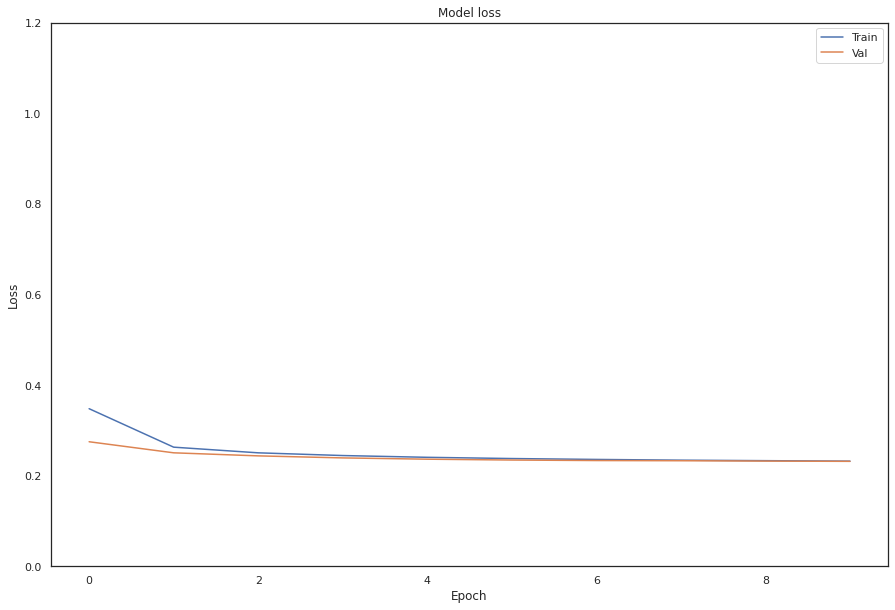

In [59]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

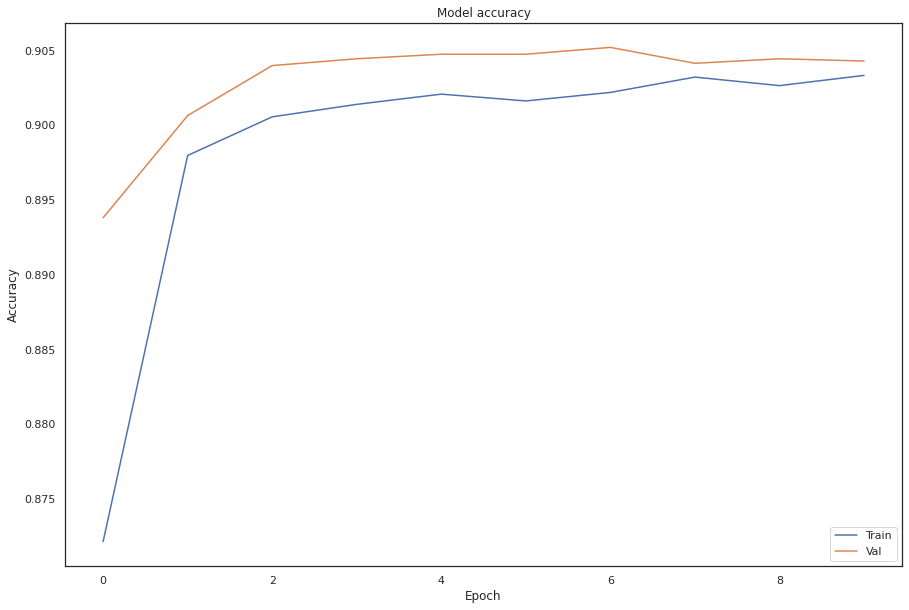

In [60]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [61]:
predictions = tf.round(model.predict(X_test)).numpy().flatten()

In [62]:
print(classification_report(y_test.values, predictions))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5840
           1       0.67      0.30      0.41       741

    accuracy                           0.90      6581
   macro avg       0.79      0.64      0.68      6581
weighted avg       0.89      0.90      0.89      6581



In [63]:
cnf_matrix = confusion_matrix(y_test, predictions)
cnf_matrix

array([[5731,  109],
       [ 521,  220]])

# 7b. Model DL 2

In [64]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu', input_shape=(14,)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),])


model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(),
                       keras.metrics.Precision()
                       ])

hist_2 = model.fit(X_train, y_train,
          batch_size=32, epochs=10,
          validation_data=(X_test, y_test))

Epoch 1/10
823/823 [==============================] - 1s 1ms/step - loss: 0.2312 - accuracy: 0.9036 - recall: 0.3193 - precision: 0.6464 - val_loss: 0.2306 - val_accuracy: 0.9047 - val_recall: 0.3482 - val_precision: 0.6418
Epoch 2/10
823/823 [==============================] - 1s 1ms/step - loss: 0.2304 - accuracy: 0.9034 - recall: 0.3277 - precision: 0.6395 - val_loss: 0.2302 - val_accuracy: 0.9056 - val_recall: 0.3414 - val_precision: 0.6554
Epoch 3/10
823/823 [==============================] - 1s 1ms/step - loss: 0.2296 - accuracy: 0.9037 - recall: 0.3260 - precision: 0.6430 - val_loss: 0.2300 - val_accuracy: 0.9061 - val_recall: 0.3468 - val_precision: 0.6573
Epoch 4/10
823/823 [==============================] - 1s 1ms/step - loss: 0.2289 - accuracy: 0.9044 - recall: 0.3318 - precision: 0.6482 - val_loss: 0.2293 - val_accuracy: 0.9058 - val_recall: 0.3414 - val_precision: 0.6571
Epoch 5/10
823/823 [==============================] - 1s 1ms/step - loss: 0.2283 - accuracy: 0.9044 - re

In [65]:
loss, accuracy, precision, recall = model_2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('F1 Score:', (2*((precision*recall)/(precision+recall))))

Test loss: 0.7116423845291138
Test accuracy: 0.1995137482881546
Test precision: 0.9271255135536194
Test recall: 0.11642094701528549
F1 Score: 0.20686540440394366


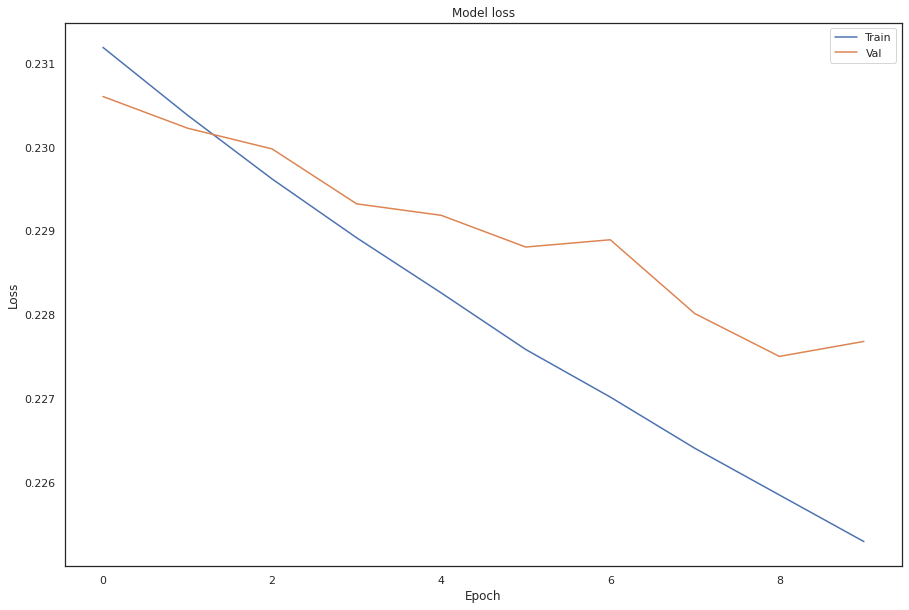

In [66]:
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

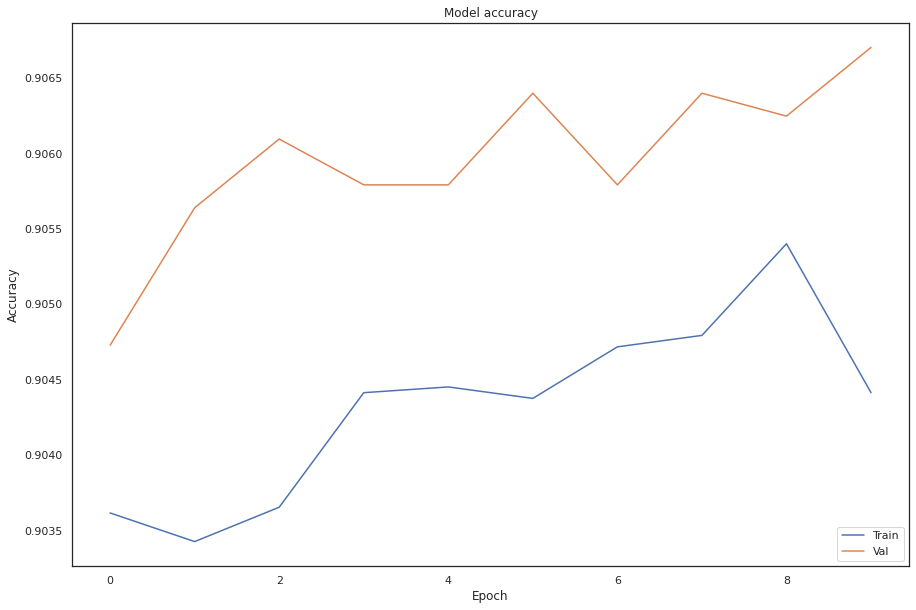

In [67]:
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [68]:
predictions2 = tf.round(model_2.predict(X_test)).numpy().flatten()

In [69]:
cnf_matrix2 = confusion_matrix(y_test, predictions2)
cnf_matrix2

array([[ 626, 5214],
       [  54,  687]])

In [70]:
precision = (354/(354+ 2752))*100
recall = (354/(354+ 387))*100
f1score = (2* ((precision*recall)/(precision*recall)))


print('precision', precision)
print('recall', recall)
print('f1score', f1score)

precision 11.397295556986478
recall 47.77327935222672
f1score 2.0


#8. Make prediction on unseen data (test data)

8a. Prepare unseen data

In [71]:
df_test = pd.read_excel('/content/drive/MyDrive/Daiichi/test_file.xlsx')
print('Test', df_test.shape)

Test (40, 14)


In [72]:
df_test.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
previous       0
poutcome       0
dtype: int64

In [73]:
df_test.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
previous        int64
poutcome       object
dtype: object

In [74]:
# Change the type

df_test['job'] = le.fit_transform(df_test['job'])
df_test['marital'] = le.fit_transform(df_test['marital'])
df_test['education'] = le.fit_transform(df_test['education'])
df_test['default'] = le.fit_transform(df_test['default'])
df_test['housing'] = le.fit_transform(df_test['housing'])
df_test['loan'] = le.fit_transform(df_test['loan'])
df_test['contact'] = le.fit_transform(df_test['contact'])
df_test['month'] = le.fit_transform(df_test['month'])
df_test['day_of_week'] = le.fit_transform(df_test['day_of_week'])
df_test['poutcome'] = le.fit_transform(df_test['poutcome'])

df_test.dtypes

age            int64
job            int64
marital        int64
education      int64
default        int64
housing        int64
loan           int64
contact        int64
month          int64
day_of_week    int64
duration       int64
campaign       int64
previous       int64
poutcome       int64
dtype: object

In [75]:
X_testset  = df_test.copy()

8b. prediction on Test unseen data

In [76]:
randomforest = RandomForestClassifier(n_estimators=350)
randomforest.fit(X_train, y_train)


result_df2 = pd.DataFrame(X_testset.values)
# X_test_scaled = scale(df_test)

prediction = pd.DataFrame(randomforest.predict(X_testset))

# format the result according to the requested format from Kaggle 
result_df2['predicted_outcome']=prediction
result_df2=result_df2.rename(columns = {0:'Id'})
result_df2.set_index('Id', inplace=True)

In [77]:
result_df2.predicted_outcome.value_counts()

0    31
1     9
Name: predicted_outcome, dtype: int64

In [84]:
result_df2

1  2  3  4  5  6  7  8  9   10  11  12  13  predicted_outcome
Id                                                               
34  6  1  2  0  0  0  1  4  2  214   4   0   1                  0
29  1  2  1  0  0  0  0  2  2  190   1   0   1                  0
35  0  2  2  0  0  0  0  4  4  152   2   0   1                  0
60  0  0  2  0  2  0  0  2  0  179   1   0   1                  0
45  3  1  4  0  0  0  1  4  4  105   2   0   1                  0
31  1  1  1  0  2  0  1  4  2  141   1   0   1                  0
39  1  1  3  0  0  0  1  4  1   87   5   0   1                  0
67  4  1  3  0  2  2  0  1  1  186   1   0   1                  1
21  7  2  2  0  0  0  0  3  2  400   1   0   1                  0
53  4  1  2  1  0  0  1  4  4  264   2   0   1                  0
51  6  1  2  1  2  0  1  4  2  102   2   0   1                  0
44  0  1  3  0  2  0  1  4  1  300   1   0   1                  1
39  8  2  3  1  0  0  1  3  1  432   4   0   1                  0
43  8  2  3  1  0  0  1  2  4   87   5   0   1                  0
50  0  1  1  0  0  0  1  3  0  116   3   0   1                  0
29  8  1  4  0  0  0  1  4  4  104   4   0   1                  0
55  9  1  4  1  1  1  1  4  1  362   1   0   1                  1
54  1  0  2  1  0  0  0  2  0  223   2   0   1                  1
29  0  2  4  0  0  2  1  3  4  251   1   0   1                  0
51  8  0  5  1  0  0  1  2  0  511   1   0   1                  1
37  8  2  2  1  2  2  1  4  3  277   4   0   1                  0
52  1  1  5  0  0  0  0  2  2  394   1   0   1                  0
50  6  1  2  0  2  0  0  2  0   60   7   0   1                  0
33  8  0  3  0  2  0  0  0  1  153   1   1   0                  1
29  1  2  2  0  2  0  0  4  1  134   2   1   0                  0
28  1  2  1  0  2  0  1  4  4  242   5   0   1                  0
32  1  1  1  0  0  0  1  4  3   59   4   0   1                  0
29  8  2  4  0  2  2  0  4  0  437   3   0   1                  0
37  5  1  4  0  2  0  0  1  0  177   1   0   1                  1
39  1  1  0  0  2  0  1  4  3  158   1   0   1                  0
30  3  1  4  0  0  2  0  2  1  833   5   0   1                  0
28  1  2  1  0  2  0  0  0  2  315   1   1   2                  1
44  2  1  3  0  2  0  1  5  1  291   3   0   1                  0
47  0  1  1  0  2  0  1  5  0   64   3   0   1                  0
29  1  1  0  0  0  0  0  4  2   16   7   0   1                  0
28  6  2  2  0  2  0  0  2  3  192   1   0   1                  0
52  8  1  3  0  2  0  0  5  0   64   1   1   0                  1
54  0  1  1  0  0  2  0  2  1  131   4   0   1                  0
29  0  1  4  0  0  0  1  4  0  165   1   0   1                  0
35  0  1  4  0  0  2  1  3  3  544   3   0   1                  0

In [78]:
# # save as csv file
# result_df2.to_csv('/content/drive/MyDrive/Daiichi/prediction_on_test_data_RFC.csv')

In [79]:
import pickle

# define model and save as sav to pull as api
model_rfc = RandomForestClassifier(n_estimators=350)
model_rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=350)

In [80]:
filename = 'finalized_model.sav'
pickle.dump(model_rfc, open(filename, 'wb'))

# apply DL Model on Unseen

In [81]:
result_df = pd.DataFrame(X_testset.values)
# X_test_scaled = scale(df_test)

prediction = pd.DataFrame(model.predict(X_testset))

# format the result according to the requested format from Kaggle 
result_df['predicted_outcome']=prediction
result_df=result_df.rename(columns = {0:'Id'})
result_df.set_index('Id', inplace=True)

# # save as csv file
# result_df.to_csv('/content/drive/MyDrive/Daiichi/prediction_on_test_data_DL.csv')

In [82]:
result_df.predicted_outcome.value_counts()

1.000000    39
0.999972     1
Name: predicted_outcome, dtype: int64

In [83]:
result_df

1  2  3  4  5  6  7  8  9   10  11  12  13  predicted_outcome
Id                                                               
34  6  1  2  0  0  0  1  4  2  214   4   0   1           1.000000
29  1  2  1  0  0  0  0  2  2  190   1   0   1           1.000000
35  0  2  2  0  0  0  0  4  4  152   2   0   1           1.000000
60  0  0  2  0  2  0  0  2  0  179   1   0   1           1.000000
45  3  1  4  0  0  0  1  4  4  105   2   0   1           1.000000
31  1  1  1  0  2  0  1  4  2  141   1   0   1           1.000000
39  1  1  3  0  0  0  1  4  1   87   5   0   1           1.000000
67  4  1  3  0  2  2  0  1  1  186   1   0   1           1.000000
21  7  2  2  0  0  0  0  3  2  400   1   0   1           1.000000
53  4  1  2  1  0  0  1  4  4  264   2   0   1           1.000000
51  6  1  2  1  2  0  1  4  2  102   2   0   1           1.000000
44  0  1  3  0  2  0  1  4  1  300   1   0   1           1.000000
39  8  2  3  1  0  0  1  3  1  432   4   0   1           1.000000
43  8  2  3  1  0  0  1  2  4   87   5   0   1           1.000000
50  0  1  1  0  0  0  1  3  0  116   3   0   1           1.000000
29  8  1  4  0  0  0  1  4  4  104   4   0   1           1.000000
55  9  1  4  1  1  1  1  4  1  362   1   0   1           1.000000
54  1  0  2  1  0  0  0  2  0  223   2   0   1           1.000000
29  0  2  4  0  0  2  1  3  4  251   1   0   1           1.000000
51  8  0  5  1  0  0  1  2  0  511   1   0   1           1.000000
37  8  2  2  1  2  2  1  4  3  277   4   0   1           1.000000
52  1  1  5  0  0  0  0  2  2  394   1   0   1           1.000000
50  6  1  2  0  2  0  0  2  0   60   7   0   1           1.000000
33  8  0  3  0  2  0  0  0  1  153   1   1   0           1.000000
29  1  2  2  0  2  0  0  4  1  134   2   1   0           1.000000
28  1  2  1  0  2  0  1  4  4  242   5   0   1           1.000000
32  1  1  1  0  0  0  1  4  3   59   4   0   1           1.000000
29  8  2  4  0  2  2  0  4  0  437   3   0   1           1.000000
37  5  1  4  0  2  0  0  1  0  177   1   0   1           1.000000
39  1  1  0  0  2  0  1  4  3  158   1   0   1           1.000000
30  3  1  4  0  0  2  0  2  1  833   5   0   1           1.000000
28  1  2  1  0  2  0  0  0  2  315   1   1   2           1.000000
44  2  1  3  0  2  0  1  5  1  291   3   0   1           1.000000
47  0  1  1  0  2  0  1  5  0   64   3   0   1           1.000000
29  1  1  0  0  0  0  0  4  2   16   7   0   1           0.999972
28  6  2  2  0  2  0  0  2  3  192   1   0   1           1.000000
52  8  1  3  0  2  0  0  5  0   64   1   1   0           1.000000
54  0  1  1  0  0  2  0  2  1  131   4   0   1           1.000000
29  0  1  4  0  0  0  1  4  0  165   1   0   1           1.000000
35  0  1  4  0  0  2  1  3  3  544   3   0   1           1.000000

# Model deployment for production

1.   Create pipepline for data source & check data drift/skew
2.   Create pipepline for data prep (structuring, feature engineering, encoding & scaling)
3. feed pipeline into model and save as API- to fed into flask/container
4. Model monitoring: test model on new dataset - data drift, features, bugs, versions & computing power using tracking api (ML flow)







In [85]:
%%shell
jupyter nbconvert --to html //content/Predicting_customer_Subscription.ipynb

[NbConvertApp] Converting notebook //content/Predicting_customer_Subscription.ipynb to html
[NbConvertApp] Writing 5413281 bytes to //content/Predicting_customer_Subscription.html
